In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

In [2]:
# loading data from task 2 to compare results

alpha = np.load("../task2/data/alpha.npy")[0]
beta = np.load("../task2/data/beta.npy")[0]
print(f"alpha = {alpha}")
print(f"beta = {beta}")

xs = np.load("../task2/data/xs.npy")[0].tolist()
ys = np.load("../task2/data/ys.npy")[0].tolist()
n = len(xs)

alpha = 0.4591910887680559
beta = 0.0379706926337019


In [3]:
def linear(x, a, b):
    return a * x + b

def rational(x, a, b):
    return a / (1 + b * x)

grad = {
    linear: lambda x, a, b: (x, 1),
    rational: lambda x, a, b: (1 / (b * x + 1), a * x / (b * x + 1) ** 2)
}

In [4]:
def D(x, f, reduce="sum"):    
    a, b = x
    result = np.array([(f(x, a, b) - y) ** 2 for x, y in zip(xs, ys)])
    if reduce == "sum":
        return result.sum()
    elif reduce == "mean":
        return result.mean()
    elif reduce == "none":
        return result
    else:
        raise Exception

def get_gradient(x, f, reduce="mean"):    
    a, b = x
    g1 = np.array([2 * grad[f](x, a, b)[0] * (f(x, a, b) - y) for x, y in zip(xs, ys)])
    g2 = np.array([2 * grad[f](x, a, b)[1] * (f(x, a, b) - y) for x, y in zip(xs, ys)])
    
    if reduce == "sum":
        return np.array([g1.sum(), g2.sum()])
    elif reduce == "mean":
        return np.array([g1.mean(), g2.mean()])
    elif reduce == "none":
        return np.stack([g1, g2]).reshape(n, -1)
    else:
        raise Exception

In [5]:
def gradient_descent(f, x0, lr=0.1, k=0.5, max_iters=100, tol=0.001):
    a_prev = b_prev = float("inf")
    a, b = x0
    t = 0  # current step
    while t < max_iters and math.sqrt((a - a_prev) ** 2 + (b - b_prev) ** 2) > tol:
        t += 1
        a_prev, b_prev = a, b
        
        # calculate gradient
        g1, g2 = get_gradient((a, b), f)
    
        # update parameters
        a -= lr * g1
        b -= lr * g2
        
        # update learning rate
        lr *= 1 / (1 + k * t)  

    return (a, b), t

## Linear approximant

In [6]:
result = gradient_descent(linear, (-0.05, 0.05), lr=0.5, k=0.25)
a_gd, b_gd = result[0]

print("Gradient descent:")
print(f"fun: {D((a_gd, b_gd), linear)}")
print(f"nit: {result[1]}")
print(f"  x: {[a_gd, b_gd]}")

Gradient descent:
fun: 87.2101345457349
nit: 4
  x: [0.0870682857100781, 0.3168199787732129]


In [7]:
f_calc = grad_calc = 0
result = optimize.minimize(D, (0.01, 0.3), args=(linear,), method='CG', tol=0.001)
a_cg, b_cg = result.x

print("Conjugate gradient descent:")
print(f"    fun: {D((a_cg, b_cg), linear)}")
print(f"    nit: {result.nit}")
print(f"   nfev: {result.nfev}")
print(f"   njev: {result.njev}")
print(f"      x: {result.x}")

Conjugate gradient descent:
    fun: 87.20546476912575
    nit: 2
   nfev: 15
   njev: 5
      x: [0.06404597 0.32941874]


In [8]:
result = optimize.minimize(D, (0, 0), args=(linear,), tol=0.001, method='Newton-CG', jac=get_gradient)
a_newt, b_newt = result.x

print("Newton's method:")
print(f"    fun: {D((a_newt, b_newt), linear)}")
print(f"    nit: {result.nit}")
print(f"   nfev: {result.nfev}")
print(f"   njev: {result.njev}")
print(f"      x: {result.x}")

Newton's method:
    fun: 87.20546476912571
    nit: 3
   nfev: 4
   njev: 11
      x: [0.06404589 0.32941879]


In [9]:
result = optimize.least_squares(D, (0, 0), args=(linear, "none"), method='lm', jac=get_gradient, xtol=0.001)
a_lm, b_lm = result.x

print("Levenberg-Marquardt algorithm:")
print(f"    fun: {D((a_lm, b_lm), linear)}")
print(f"   nfev: {result.nfev}")
print(f"   njev: {result.njev}")
print(f"success: {result.success}")
print(f"      x: {result.x}")

Levenberg-Marquardt algorithm:
    fun: 87.25244572309289
   nfev: 9
   njev: 3
success: True
      x: [0.05294717 0.31364475]


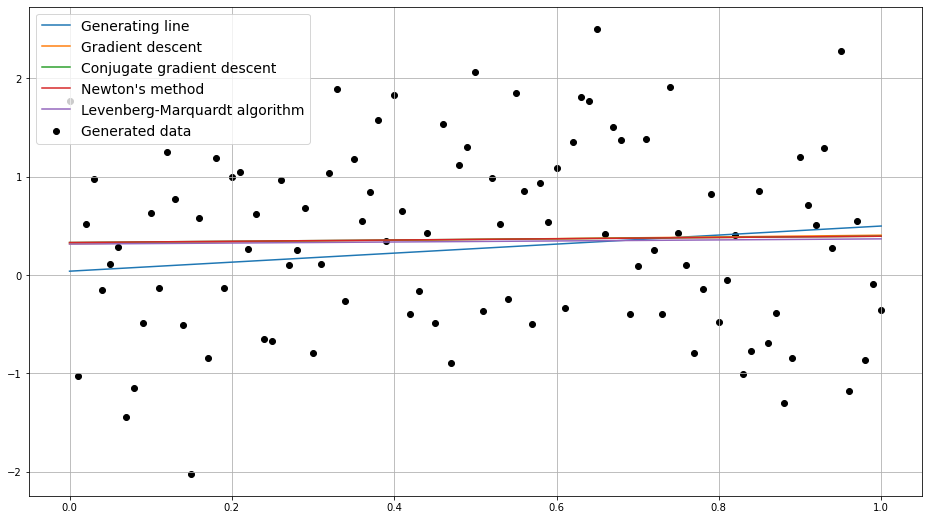

In [10]:
plt.figure(figsize=(16, 9))
plt.grid()
plt.scatter(xs, ys, color="black")
plt.plot(xs, [linear(x, alpha, beta) for x in xs])
plt.plot(xs, [linear(x, a_gd, b_gd) for x in xs])
plt.plot(xs, [linear(x, a_cg, b_cg) for x in xs])
plt.plot(xs, [linear(x, a_newt, b_newt) for x in xs])
plt.plot(xs, [linear(x, a_lm, b_lm) for x in xs])
plt.legend(["Generating line", "Gradient descent", "Conjugate gradient descent", "Newton's method", "Levenberg-Marquardt algorithm", "Generated data"],
           fontsize=14)
plt.show()

## Rational approximant

In [11]:
result = gradient_descent(rational, (0, 0), lr=0.7, k=0.5)
a_gd, b_gd = result[0]

print("Gradient descent:")
print(f"fun: {D((a_gd, b_gd), rational)}")
print(f"nit: {result[1]}")
print(f"  x: {[a_gd, b_gd]}")

Gradient descent:
fun: 87.23417869856331
nit: 5
  x: [0.3617578707905768, -0.03246081312450849]


In [12]:
result = optimize.minimize(D, (0, 0), args=(rational,), method='CG', tol=0.001)
a_cg, b_cg = map(float, result.x)

print("Conjugate gradient descent:")
print(f"    fun: {D((a_cg, b_cg), rational)}")
print(f"    nit: {result.nit}")
print(f"   nfev: {result.nfev}")
print(f"   njev: {result.njev}")
print(f"      x: {result.x}")

Conjugate gradient descent:
    fun: 87.22501990442771
    nit: 6
   nfev: 36
   njev: 12
      x: [ 0.34769893 -0.07566702]


In [13]:
result = optimize.minimize(D, (0, 0), args=(rational,), method='Newton-CG', jac=get_gradient, tol=0.001)
a_newt, b_newt = result.x

print("Newton's method:")
print(f"    fun: {D((a_newt, b_newt), rational)}")
print(f"    nit: {result.nit}")
print(f"   nfev: {result.nfev}")
print(f"   njev: {result.njev}")
print(f"      x: {result.x}")

Newton's method:
    fun: 87.24067940327784
    nit: 1
   nfev: 18
   njev: 8
      x: [0.36144173 0.        ]


In [14]:
result = optimize.least_squares(D, (1, 1), args=(rational, "none"), method='lm', jac=get_gradient, xtol=0.001)
a_lm, b_lm = result.x

print("Levenberg-Marquardt algorithm:")
print(f"    fun: {D((a_lm, b_lm), rational)}")
print(f"   nfev: {result.nfev}")
print(f"   njev: {result.njev}")
print(f"success: {result.success}")
print(f"      x: {result.x}")

Levenberg-Marquardt algorithm:
    fun: 87.82102577390567
   nfev: 13
   njev: 5
success: True
      x: [0.37181689 0.39898828]


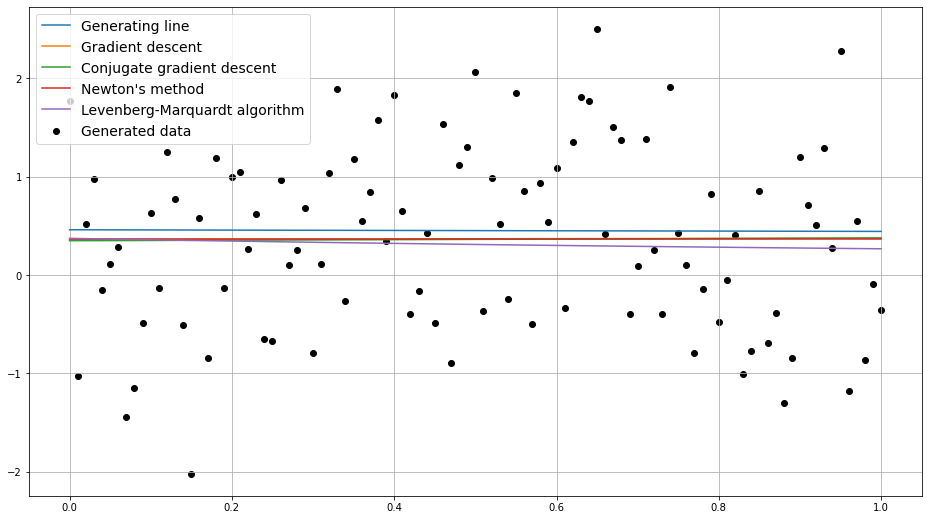

In [15]:
plt.figure(figsize=(16, 9))
plt.grid()
plt.scatter(xs, ys, color="black")
plt.plot(xs, [rational(x, alpha, beta) for x in xs])
plt.plot(xs, [rational(x, a_gd, b_gd) for x in xs])
plt.plot(xs, [rational(x, a_cg, b_cg) for x in xs])
plt.plot(xs, [rational(x, a_newt, b_newt) for x in xs])
plt.plot(xs, [rational(x, a_lm, b_lm) for x in xs])
plt.legend(["Generating line", "Gradient descent", "Conjugate gradient descent", "Newton's method", "Levenberg-Marquardt algorithm", "Generated data"],
           fontsize=14)
plt.show()